# A tensorflow model for Dictionary Filter

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

2024-07-09 20:58:17.411895: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 20:58:17.436275: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 20:58:17.825510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
sys.path.append('../Library')

from Metrics.NMSE import NMSE
from Modules.BatchGaussianDF import BatchGaussianDF as DictionaryFilter

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Test on Movie Lens 25M dataset

In [4]:
# Read the dataset
dataset = pd.read_csv('../Data/MovieLens/Recommended/dataset.csv')

# Display the dataset
dataset.head()

,Movie Index,User Index,Rating
0,7242,58197,3.5
1,21105,149680,4.0
2,6762,15512,4.5
3,2538,128,3.0
4,522,112086,5.0


In [5]:
from sklearn.model_selection import train_test_split
from AdvancedModelSelection import user_based_train_test_split

# Split the dataset into train and test data
train_val_data, test_data = user_based_train_test_split(dataset, test_size=0.2, random_state=42)

# Split the train and validation data
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# Print the shapes of train and test data
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (18000798, 3)
Validation data shape: (2000089, 3)
Test data shape: (4999208, 3)


In [6]:
NUM_MOVIES = dataset['Movie Index'].max() + 1
NUM_USERS = dataset['User Index'].max() + 1
NUM_FACTORS = 16
BATCH_SIZE = 32
SIGMA = 0.2
INIT_SCALE = dataset['Rating'].mean() / NUM_FACTORS
NUM_EPOCHS = 20

In [7]:
# Convert train data to sparse tensor
train_sparse_tensor = tf.sparse.SparseTensor(
    indices=train_data[['Movie Index', 'User Index']].values,
    values=train_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
train_sparse_tensor = tf.sparse.reorder(train_sparse_tensor)

# Convert validation data to sparse tensor
val_sparse_tensor = tf.sparse.SparseTensor(
    indices=val_data[['Movie Index', 'User Index']].values,
    values=val_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
val_sparse_tensor = tf.sparse.reorder(val_sparse_tensor)

# Convert test data to sparse tensor
test_sparse_tensor = tf.sparse.SparseTensor(
    indices=test_data[['Movie Index', 'User Index']].values,
    values=test_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
test_sparse_tensor = tf.sparse.reorder(test_sparse_tensor)

2024-07-09 20:58:56.553364: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 20:58:56.569392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 20:58:56.569449: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 20:58:56.570610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-09 20:58:56.570647: I external/local_xla/xla/stream_executor

In [8]:
# Create dataset
def create_train_dataset(batch_size=BATCH_SIZE):
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        val_slices = tf.sparse.split(sp_input=val_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        for i in range(NUM_USERS // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(val_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32)
        )
    )

    return dataset

def create_full_dataset(batch_size=BATCH_SIZE):
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        val_slices = tf.sparse.split(sp_input=val_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        test_slices = tf.sparse.split(sp_input=test_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        for i in range(NUM_USERS // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(val_slices[i]), tf.sparse.to_dense(test_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32)
        )
    )

    return dataset

## Experiments

### 3. Number of epochs vs NMSE

In [9]:
# Initialize variables
nmse_train_results = np.zeros(NUM_EPOCHS)
nmse_val_results = np.zeros(NUM_EPOCHS)
nmse_test_results = np.zeros(NUM_EPOCHS)

# Create the model
model = DictionaryFilter(NUM_MOVIES, NUM_FACTORS, INIT_SCALE, SIGMA)
nmse_train = NMSE()
nmse_val = NMSE()
nmse_test = NMSE()

# Create the dataset
dataset = create_full_dataset()

# Train the model
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(total=NUM_USERS // BATCH_SIZE, desc=f"Epoch {epoch+1}", unit="batch")
    
    for train_batch, val_batch, test_batch in dataset:
        x = model(train_batch)
        nmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
        nmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
        nmse_test.update_state(test_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(test_batch, 0.0), tf.float32))
        progress_bar.update(1)
    
    progress_bar.close()

    print("Train NMSE:", nmse_train.result().numpy())
    print("Val NMSE:", nmse_val.result().numpy())
    print("Test NMSE:", nmse_test.result().numpy())
    nmse_train_results[epoch] = nmse_train.result().numpy()
    nmse_val_results[epoch] = nmse_val.result().numpy()
    nmse_test_results[epoch] = nmse_test.result().numpy()

Epoch 1: 100%|██████████| 5079/5079 [08:39<00:00,  9.78batch/s]


Train NMSE: 0.053444315
Val NMSE: 0.06548696
Test NMSE: 0.06552806


Epoch 2: 100%|██████████| 5079/5079 [08:30<00:00,  9.95batch/s]


Train NMSE: 0.05317363
Val NMSE: 0.06506505
Test NMSE: 0.06509925


Epoch 3: 100%|██████████| 5079/5079 [08:29<00:00,  9.96batch/s]


Train NMSE: 0.053021777
Val NMSE: 0.06482216
Test NMSE: 0.06485248


Epoch 4: 100%|██████████| 5079/5079 [08:30<00:00,  9.95batch/s]


Train NMSE: 0.052917406
Val NMSE: 0.06465724
Test NMSE: 0.06469138


Epoch 5: 100%|██████████| 5079/5079 [08:29<00:00,  9.97batch/s]


Train NMSE: 0.052836966
Val NMSE: 0.06452745
Test NMSE: 0.06455962


Epoch 6: 100%|██████████| 5079/5079 [08:31<00:00,  9.93batch/s]


Train NMSE: 0.052771736
Val NMSE: 0.06442264
Test NMSE: 0.06445738


Epoch 7: 100%|██████████| 5079/5079 [08:39<00:00,  9.78batch/s]


Train NMSE: 0.052717403
Val NMSE: 0.06433394
Test NMSE: 0.064369634


Epoch 8: 100%|██████████| 5079/5079 [08:30<00:00,  9.96batch/s]


Train NMSE: 0.05267029
Val NMSE: 0.06425487
Test NMSE: 0.06429141


Epoch 9: 100%|██████████| 5079/5079 [08:35<00:00,  9.86batch/s]


Train NMSE: 0.052629475
Val NMSE: 0.06418747
Test NMSE: 0.06422408


Epoch 10: 100%|██████████| 5079/5079 [08:27<00:00, 10.00batch/s]


Train NMSE: 0.05259331
Val NMSE: 0.06412669
Test NMSE: 0.064165846


Epoch 11: 100%|██████████| 5079/5079 [08:59<00:00,  9.42batch/s]


Train NMSE: 0.052560825
Val NMSE: 0.064074524
Test NMSE: 0.06411125


Epoch 12: 100%|██████████| 5079/5079 [08:18<00:00, 10.18batch/s]


Train NMSE: 0.05253111
Val NMSE: 0.064024165
Test NMSE: 0.06406214


Epoch 13: 100%|██████████| 5079/5079 [08:23<00:00, 10.09batch/s]


Train NMSE: 0.052503962
Val NMSE: 0.063979685
Test NMSE: 0.06401806


Epoch 14: 100%|██████████| 5079/5079 [08:21<00:00, 10.12batch/s]


Train NMSE: 0.05247885
Val NMSE: 0.06393966
Test NMSE: 0.06397716


Epoch 15: 100%|██████████| 5079/5079 [08:25<00:00, 10.05batch/s]


Train NMSE: 0.052455753
Val NMSE: 0.06390162
Test NMSE: 0.063939385


Epoch 16: 100%|██████████| 5079/5079 [08:27<00:00, 10.01batch/s]


Train NMSE: 0.05243381
Val NMSE: 0.06386645
Test NMSE: 0.06390374


Epoch 17: 100%|██████████| 5079/5079 [08:31<00:00,  9.93batch/s]


Train NMSE: 0.05241354
Val NMSE: 0.063833944
Test NMSE: 0.063870355


Epoch 18: 100%|██████████| 5079/5079 [08:43<00:00,  9.70batch/s]


Train NMSE: 0.0523947
Val NMSE: 0.0638026
Test NMSE: 0.06383854


Epoch 19: 100%|██████████| 5079/5079 [08:25<00:00, 10.05batch/s]


Train NMSE: 0.052377146
Val NMSE: 0.06377237
Test NMSE: 0.06380909


Epoch 20: 100%|██████████| 5079/5079 [08:14<00:00, 10.26batch/s]

Train NMSE: 0.052360035
Val NMSE: 0.06374551
Test NMSE: 0.063781224


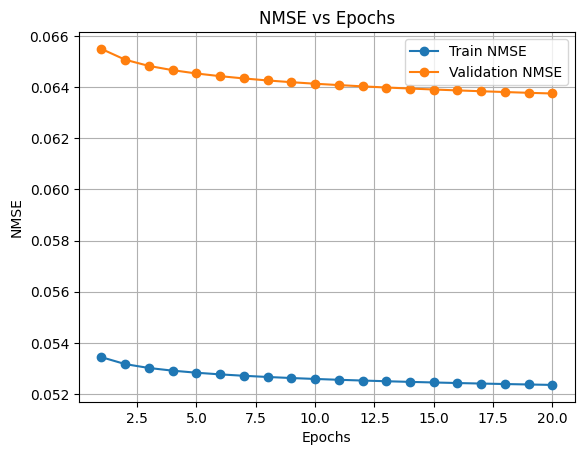

In [10]:
# Plot NMSE vs number of epochs
plt.plot(np.arange(1, NUM_EPOCHS+1), nmse_train_results, marker='o', label='Train NMSE')
plt.plot(np.arange(1, NUM_EPOCHS+1), nmse_val_results, marker='o', label='Validation NMSE')
plt.xlabel('Epochs')
plt.ylabel('NMSE')
plt.title('NMSE vs Epochs')
plt.legend()
plt.grid()
plt.show()

In [11]:
# # Save results to a CSV file
# results = pd.DataFrame({
#     'Train Results': nmse_train_results,
#     'Test Results': nmse_test_results
# })
# results.to_csv('Results/ML25M/num_epochs.csv', index=False)

## Observations

1. The gradient descend update for $X$ worked on test matrices:

$$
X^{(2)} = X^{(1)} - \gamma \nabla_X ||Y - CX||^2 = X^{(1)} - \gamma C^T (CX - Y)
$$

2. However the masked approximation did not converge on MovieLens 100k dataset:

$$
X^{(2)} = X^{(1)} - \gamma C^T (M \odot CX - M \odot Y)
$$

3. The updates for $C$ and $V$ from MVGMF took longer to run due to $n \times n$ (batch size by batch size) matrix inversions while the averaging updates of DF do not involve such operations.

4. Using MVGMF updates for $C$ and $V$ did not improve the algorithm's performance in term of NMSE.